# Downloading requirements

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_c0xbhzk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_c0xbhzk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
!pip install clip
!pip install openai

# Loading dataset

In [3]:
from torchvision.datasets import Food101

# Specify the directory where the dataset will be stored
root_dir = '/Data'

# Create a Food101 dataset instance and download the dataset
food101_dataset = Food101(root=root_dir, download=True)

In [4]:
food101_dataset_train = Food101(root=root_dir, split='train', download=True)

In [5]:
len(food101_dataset_train)

75750

# Some Libraries

In [6]:
import clip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split
from torch.optim import Adam
from torchvision.models import resnet18
from torchvision import transforms as transforms
from matplotlib import pyplot as plt

In [7]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

**Loading CLip with ResNet50**

In [ ]:
# model and transformations
model, transform = clip.load("RN50", device=device)

**Dataloaders**

In [31]:

# Applying transformations to the dataset
food101_dataset_train.transform = transform

# lengths of train and validation set
train_len = int(len(food101_dataset_train) * 0.8)
val_len = len(food101_dataset_train) - train_len

# Splitting the dataset
train_set, val_set = random_split(food101_dataset_train, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [32]:
len(train_loader),len(val_loader)

(947, 237)

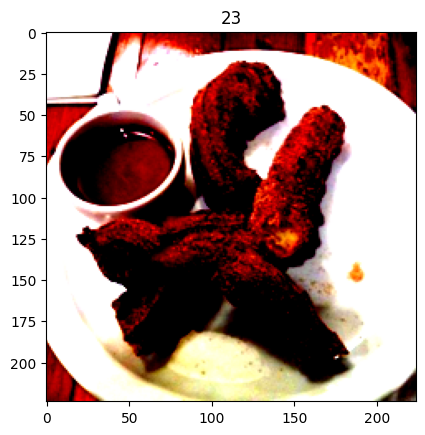

In [11]:
plt.imshow(food101_dataset_train[0][0].permute(1,2,0))
plt.title(food101_dataset_train[0][1])
plt.show()

In [12]:
# Get the list of class names
class_names = food101_dataset_train.classes

label_mapping={}
# Print the class names
for i, name in enumerate(class_names):
    label_mapping[i]=name
#     print(f"Label ID: {i}, Class Name: {name}")
label_mapping


{0: 'apple_pie',
 1: 'baby_back_ribs',
 2: 'baklava',
 3: 'beef_carpaccio',
 4: 'beef_tartare',
 5: 'beet_salad',
 6: 'beignets',
 7: 'bibimbap',
 8: 'bread_pudding',
 9: 'breakfast_burrito',
 10: 'bruschetta',
 11: 'caesar_salad',
 12: 'cannoli',
 13: 'caprese_salad',
 14: 'carrot_cake',
 15: 'ceviche',
 16: 'cheese_plate',
 17: 'cheesecake',
 18: 'chicken_curry',
 19: 'chicken_quesadilla',
 20: 'chicken_wings',
 21: 'chocolate_cake',
 22: 'chocolate_mousse',
 23: 'churros',
 24: 'clam_chowder',
 25: 'club_sandwich',
 26: 'crab_cakes',
 27: 'creme_brulee',
 28: 'croque_madame',
 29: 'cup_cakes',
 30: 'deviled_eggs',
 31: 'donuts',
 32: 'dumplings',
 33: 'edamame',
 34: 'eggs_benedict',
 35: 'escargots',
 36: 'falafel',
 37: 'filet_mignon',
 38: 'fish_and_chips',
 39: 'foie_gras',
 40: 'french_fries',
 41: 'french_onion_soup',
 42: 'french_toast',
 43: 'fried_calamari',
 44: 'fried_rice',
 45: 'frozen_yogurt',
 46: 'garlic_bread',
 47: 'gnocchi',
 48: 'greek_salad',
 49: 'grilled_chees

In [16]:
image=food101_dataset[0][0]
image_input = transform(image).unsqueeze(0).to(device)
with torch.no_grad():
    image_embedding = model.encode_image(image_input)
image_embedding.shape

torch.Size([1, 1024])

# Model Architecture

In [27]:
class CLIPLinearClassifier(nn.Module):
    def __init__(self,num_classes=101):
        super().__init__()
        self.classifier =nn.Sequential(*[
            nn.Linear(1024, 200),
            nn.Linear(200,num_classes)
        ])

    def forward(self, x):
        with torch.no_grad():
          x=model.encode_image(x)
        x=x.float()
        x = self.classifier(x)
        return x


CLIP_model=CLIPLinearClassifier()
CLIP_model=CLIP_model.to(device)

**Just counting number of parameters**

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count the parameters in the CLIP model
clip_parameters = count_parameters(model)
print(f"The CLIP model has {clip_parameters} trainable parameters.")

# Count the parameters in your classifier
classifier_parameters = count_parameters(CLIP_model)
print(f"The classifier has {classifier_parameters} trainable parameters.")

# Count the total parameters
total_parameters = clip_parameters + classifier_parameters
print(f"The total number of trainable parameters is {total_parameters}.")

The CLIP model has 102007137 trainable parameters.
The classifier has 225301 trainable parameters.
The total number of trainable parameters is 102232438.


In [28]:
for x,y in train_loader:
  with torch.no_grad():
    x=x.float().to(device)
    print(CLIP_model(x).shape)
  break

torch.Size([64, 101])


# Training

In [33]:
lr=0.01;epochs=2
optimizer=Adam(params=CLIP_model.parameters(),lr=lr)
loss_fn=nn.CrossEntropyLoss()
CLIP_model=CLIP_model.to(device)


def evaluate(model,test_loader,loss_fn):
    with torch.no_grad():
        track_loss=0
        num_correct=0
        for i,(imgs,labels) in enumerate(test_loader):
            imgs=imgs.to(device);labels=labels.to(device)
            pred=model(imgs)
            num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
            loss=loss_fn(pred,labels)
            track_loss+=loss.item()
        print(f'validation_loss: {track_loss/(len(test_loader))}  | accuracy: {num_correct*100/((len(test_loader))*64)}')
        return num_correct*100/((len(test_loader))*64)


loss_tracking=[];accuracy_tracking=[]
for epoch in range(epochs):
    track_loss=0
    num_correct=0
    for i,(imgs,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        imgs=imgs.to(device);labels=labels.to(device)
        pred=CLIP_model(imgs)
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()
        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        loss.backward()
        optimizer.step()
        if i%50==0:
            print(f'Batch-{i+1} |  avg_loss till now: {track_loss/(i+1)}  | accuracy: {num_correct*100/((i+1)*64)}')
    print(f'epoch:{epoch} epoch_loss: {track_loss/(len(train_loader))}  | accuracy: {num_correct*100/((len(train_loader))*64)}')
    loss_tracking.append(track_loss/(len(train_loader)))
    acc=num_correct*100/((len(train_loader))*64)
    accuracy_tracking.append(acc)
    temp=evaluate(CLIP_model,val_loader,loss_fn)
    print('_____________________________________\n\n')



Batch-1 |  avg_loss till now: 1.2016195058822632  | accuracy: 65.625
Batch-51 |  avg_loss till now: 1.1436226262765772  | accuracy: 69.57720588235294
Batch-101 |  avg_loss till now: 1.1061644914126632  | accuracy: 70.54455445544555
Batch-151 |  avg_loss till now: 1.1184549702713822  | accuracy: 70.40562913907284
Batch-201 |  avg_loss till now: 1.0897526907090525  | accuracy: 70.86442786069652
Batch-251 |  avg_loss till now: 1.0968679833222195  | accuracy: 70.89143426294821
Batch-301 |  avg_loss till now: 1.0940623356654398  | accuracy: 71.06000830564784
Batch-351 |  avg_loss till now: 1.0857431868202665  | accuracy: 71.4031339031339
Batch-401 |  avg_loss till now: 1.088291471884435  | accuracy: 71.46976309226933
Batch-451 |  avg_loss till now: 1.08953823363966  | accuracy: 71.54587028824834
Batch-501 |  avg_loss till now: 1.0901143127334807  | accuracy: 71.51010479041916
Batch-551 |  avg_loss till now: 1.0942347115700128  | accuracy: 71.5630671506352
Batch-601 |  avg_loss till now: 1.0

**Saving model**

In [34]:
torch.save(CLIP_model.state_dict(), 'CLIP_model_weights.pth')

**Loading model**

In [ ]:
# Load the model parameters
CLIP_model.load_state_dict(torch.load('CLIP_model_weights.pth'))

# Inference time

**Identifying food**

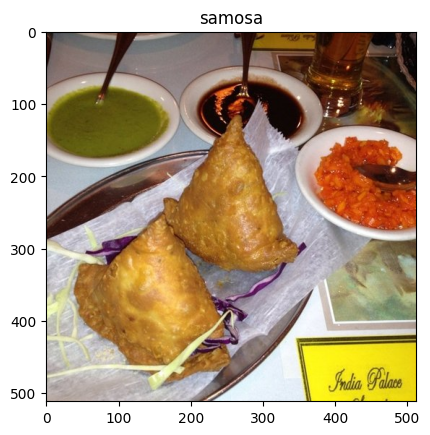

In [60]:
def identify_food(image,display=False):
  image_input = transform(image).unsqueeze(0).to(device)
  with torch.no_grad():
      predictions = CLIP_model(image_input)
  label=predictions.argmax(dim=-1)
  if display:
    plt.imshow(image)
    plt.title(label_mapping[label.item()])
    plt.show()
  return label.item(),label_mapping[label.item()]

image=food101_dataset[1500][0]
temp=identify_food(image,True)

**Mapping food with corrisponding calorie**

In [57]:
calorie_dict = {
    0: 'high',    # apple_pie
    1: 'high',    # baby_back_ribs
    2: 'high',    # baklava
    3: 'low',     # beef_carpaccio
    4: 'medium',  # beef_tartare
    5: 'low',     # beet_salad
    6: 'high',    # beignets
    7: 'medium',  # bibimbap
    8: 'high',    # bread_pudding
    9: 'high',    # breakfast_burrito
    10: 'low',    # bruschetta
    11: 'medium', # caesar_salad
    12: 'high',   # cannoli
    13: 'low',    # caprese_salad
    14: 'high',   # carrot_cake
    15: 'low',    # ceviche
    16: 'medium', # cheese_plate
    17: 'high',   # cheesecake
    18: 'medium', # chicken_curry
    19: 'high',   # chicken_quesadilla
    20: 'high',   # chicken_wings
    21: 'high',    # chocolate_cake
    22: 'high',    # chocolate_mousse
    23: 'medium',  # churros
    24: 'medium',  # clam_chowder
    25: 'high',    # club_sandwich
    26: 'medium',  # crab_cakes
    27: 'high',    # creme_brulee
    28: 'medium',  # croque_madame
    29: 'high',    # cup_cakes
    30: 'low',     # deviled_eggs
    31: 'high',    # donuts
    32: 'medium',  # dumplings
    33: 'low',     # edamame
    34: 'medium',  # eggs_benedict
    35: 'medium',  # escargots
    36: 'low',     # falafel
    37: 'high',    # filet_mignon
    38: 'high',    # fish_and_chips
    39: 'high',    # foie_gras
    40: 'high',    # french_fries
    41: 'medium',  # french_onion_soup
    42: 'medium',  # french_toast
    43: 'medium',  # fried_calamari
    44: 'medium',  # fried_rice
    45: 'low',     # frozen_yogurt
    46: 'medium',  # garlic_bread
    47: 'medium',  # gnocchi
    48: 'low',     # greek_salad
    49: 'medium',  # grilled_cheese_sandwich
    50: 'medium',  # grilled_salmon
    51: 'medium',  # guacamole
    52: 'medium',  # gyoza
    53: 'high',    # hamburger
    54: 'low',     # hot_and_sour_soup
    55: 'high',    # hot_dog
    56: 'medium',  # huevos_rancheros
    57: 'low',     # hummus
    58: 'high',    # ice_cream
    59: 'high',    # lasagna
    60: 'medium',  # lobster_bisque
    61: 'high',    # lobster_roll_sandwich
    62: 'high',    # macaroni_and_cheese
    63: 'medium',  # macarons
    64: 'low',     # miso_soup
    65: 'medium',  # mussels
    66: 'high',    # nachos
    67: 'medium',  # omelette
    68: 'high',    # onion_rings
    69: 'low',     # oysters
    70: 'medium',  # pad_thai
    71: 'high',    # paella
    72: 'medium',  # pancakes
    73: 'medium',  # panna_cotta
    74: 'high',    # peking_duck
    75: 'low',     # pho
    76: 'high',    # pizza
    77: 'high',    # pork_chop
    78: 'high',    # poutine
    79: 'high',    # prime_rib
    80: 'high',    # pulled_pork_sandwich
    81: 'medium',  # ramen
    82: 'medium',  # ravioli
    83: 'high',    # red_velvet_cake
    84: 'medium',  # risotto
    85: 'medium',  # samosa
    86: 'low',     # sashimi
    87: 'medium',  # scallops
    88: 'low',     # seaweed_salad
    89: 'high',    # shrimp_and_grits
    90: 'high',    # spaghetti_bolognese
    91: 'high',    # spaghetti_carbonara
    92: 'low',     # spring_rolls
    93: 'high',    # steak
    94: 'medium',  # strawberry_shortcake
    95: 'medium',  # sushi
    96: 'medium',  # tacos
    97: 'medium',  # takoyaki
    98: 'high',    # tiramisu
    99: 'low',     # tuna_tartare
    100: 'medium'  # waffles
}

In [66]:
def identify_calorie_content_of_food(image,display=False):
  id,name=identify_food(image)
  text=f'''That is {name} !!
  which is generally {calorie_dict[id]} in calories'''
  if display:
    plt.imshow(image)
    plt.title(text)
    plt.show()


  return text

# Some results

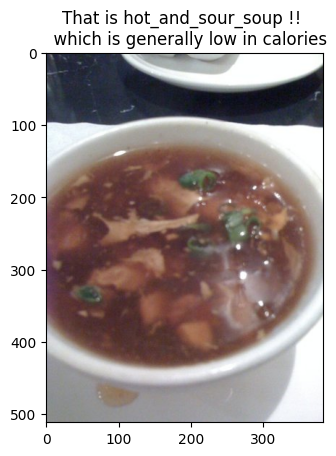

In [74]:
image=food101_dataset[1000][0]

text=identify_calorie_content_of_food(image,display=True)

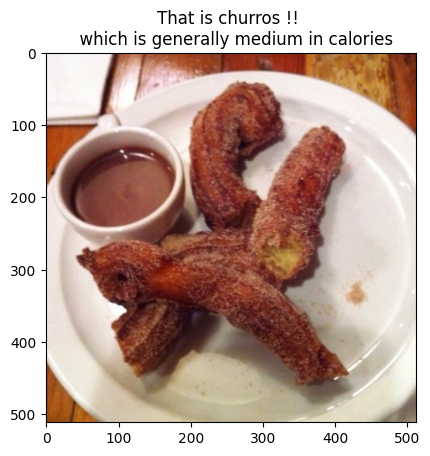

In [75]:
image=food101_dataset[0][0]

text=identify_calorie_content_of_food(image,display=True)

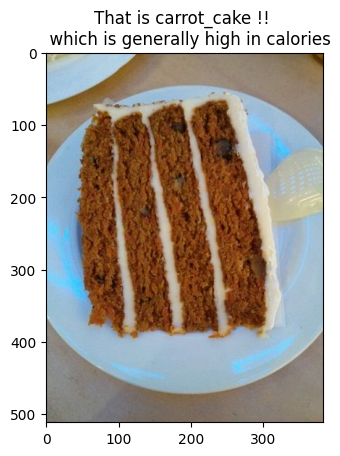

In [77]:
image=food101_dataset[20000][0]

text=identify_calorie_content_of_food(image,display=True)

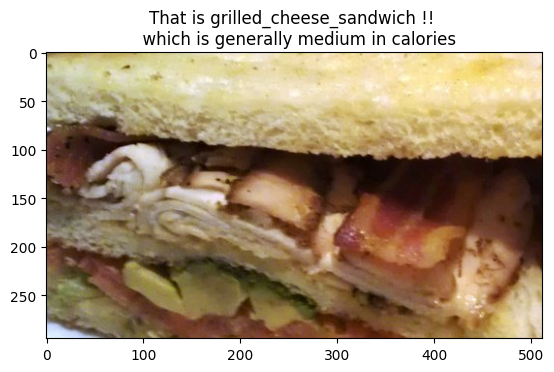

In [76]:
image=food101_dataset[19000][0]

text=identify_calorie_content_of_food(image,display=True)